In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from scipy.special import erf
from datetime import datetime
%matplotlib inline

In [0]:
import pandas as pd
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

country = 'Spain'
full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table_US = full_table[full_table['Country/Region'] == country]
full_table_US.reset_index(drop = True,inplace =True)
full = full_table_US

In [3]:
full

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Spain,2020-01-22,0,0,0
1,,Spain,2020-01-23,0,0,0
2,,Spain,2020-01-24,0,0,0
3,,Spain,2020-01-25,0,0,0
4,,Spain,2020-01-26,0,0,0
...,...,...,...,...,...,...
110,,Spain,2020-05-11,227436,26744,137139
111,,Spain,2020-05-12,228030,26920,138980
112,,Spain,2020-05-13,228691,27104,140823
113,,Spain,2020-05-14,229540,27321,143374


In [0]:
# TODO: automate for each country
N= 46751619


dataConfirmedUS = confirmed_df[confirmed_df['Country/Region']==country].loc[:, '1/22/20':].iloc[0]
dataRecoveredUS = recovered_df[recovered_df['Country/Region']==country].loc[:, '1/22/20':].iloc[0]
dataDeathUS = death_df[death_df['Country/Region']==country].loc[:, '1/22/20':].iloc[0]

In [5]:
dataConfirmedUS

1/22/20         0
1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
            ...  
5/11/20    227436
5/12/20    228030
5/13/20    228691
5/14/20    229540
5/15/20    230183
Name: 201, Length: 115, dtype: int64

In [6]:
full['Confirmed']

0           0
1           0
2           0
3           0
4           0
        ...  
110    227436
111    228030
112    228691
113    229540
114    230183
Name: Confirmed, Length: 115, dtype: int64

In [7]:
nbdays = (datetime.today() - datetime.strptime('1/22/20', '%m/%d/%y')).days + 1
nbdays

116

#### SIER

In [0]:
from datetime import timedelta, datetime
def extend_index(index, new_size):
    values = index.values
    current = datetime.strptime(index[-1], '%m/%d/%y')
    while len(values) < new_size:
        current = current + timedelta(days=1)
        values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
    return values


In [0]:
def lossSEIR(point, data, recovered, N, s_0, e_0, i_0, r_0):
    size = len(data)
    alpha, beta, gamma = point

    #print(alpha, beta, gamma,)

    def SEIR(t, y):
        S = y[0]
        E = y[1]
        I = y[2]
        R = y[3]
        return [-beta*S*I/N, beta*S*I/N - alpha*E, alpha*E - gamma*I, gamma*I]
    solution = solve_ivp(SEIR, [0, size], [s_0,e_0,i_0,r_0],
                         t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[2] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[3] - recovered)**2))
    alpha = 0.15
    return alpha * l1 + (1 - alpha) * l2

In [10]:
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

data = full['Confirmed'] - full['Recovered'] - full['Deaths']
###
s_0 = N
e_0 = 1
i_0 = 1
r_0 = 0
###
result = minimize(lossSEIR,
                  [0.1,0.1,0.1],
                  args=(data.astype('float64'), full['Recovered'].astype('float64'), N, s_0, e_0, i_0, r_0),
                  method='L-BFGS-B',
                  bounds=[(0., 5.), (0., 10.), (0., 5.)])#, bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
alpha, beta, gamma = result.x
print(alpha, beta, gamma)

5.0 4.887558082038011 4.747756815934997


In [11]:
print('Sigma :',alpha,'\nBeta :', beta,'\nGamma :', gamma,'\nR0 :', beta/gamma)

Sigma : 5.0 
Beta : 4.887558082038011 
Gamma : 4.747756815934997 
R0 : 1.029445751230096


In [0]:
def SEIR(t, y):
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]
    return [- beta*S*I/N, beta*S*I/N - alpha*E, alpha*E - gamma*I, gamma*I]

In [0]:
predict_range = nbdays + 120

new_index = extend_index(dataConfirmedUS.index, predict_range)
size = len(new_index)

predictUS = solve_ivp(SEIR,
                           [0, size],
                           [s_0,e_0,i_0,r_0],
                           t_eval=np.arange(0, size, 1))

In [14]:
predictUS

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 4808
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 1

In [0]:
def get_pred_data(date:str):
    start_date = '2020-01-22'
    start_date_obj = datetime.strptime(start_date,'%Y-%m-%d')
    date_obj = datetime.strptime(date,'%Y-%m-%d')
    days_from_start = (date_obj - start_date_obj).days
    # result = int(S[days_from_start]),int(I[days_from_start]),int(R[days_from_start])
    result = int(predictUS.y[0,days_from_start]),int(predictUS.y[1,days_from_start]),int(predictUS.y[2,days_from_start]),int(predictUS.y[3,days_from_start])
    results = {'Susceptible' : [result[0]],'Exposed' : [result[1]],'Infected' : [result[2]],'Recovered' : [result[3]]}
    return pd.DataFrame(results)

def get_real_data(date:str):
    date_obj = datetime.strptime(date,'%Y-%m-%d')
    stats = full.loc[full['Date'] == date_obj, ['Confirmed','Deaths','Recovered']]
    sus = int(N - stats.iloc[0][0]-stats.iloc[0][1]-stats.iloc[0][2])
    results = {'Susceptible' : [sus],'Infected' : [stats.iloc[0][0]],'Recovered' : [stats.iloc[0][2]]}
    return pd.DataFrame(results)

def get_diff_data(date:str):
    start_date = '2020-01-22'
    start_date_obj = datetime.strptime(start_date,'%Y-%m-%d')
    date_obj = datetime.strptime(date,'%Y-%m-%d')
    stats = full.loc[full['Date'] == date_obj, ['Confirmed','Recovered','Deaths']]
    sus = int(N - stats.iloc[0][0]-stats.iloc[0][1]-stats.iloc[0][2])
    stats = sus,stats.iloc[0][0],stats.iloc[0][1]

    days_from_start = (date_obj - start_date_obj).days
    result = int(predictUS.y[0,days_from_start]),int(predictUS.y[2,days_from_start]),int(predictUS.y[3,days_from_start])
    diff = []
    for i in range(3):
        diff.append(result[i] - stats[i])
    data = {'Susceptible_Difference' : [diff[0]],'Infected_Difference' : [diff[1]],'Recovered_Difference' : [diff[2]]}
    return pd.DataFrame(data)

    


def get_diff_data_all():
    start_date = '2020-01-22'
    start_date_obj = datetime.strptime(start_date,'%Y-%m-%d')
    end_date_obj = datetime.today()
    # end_date_obj = datetime.strptime(end_date,'%Y-%m-%d')
    sus_diff = []
    inf_diff = []
    rec_diff = []
    dates = []
    days = end_date_obj - start_date_obj
    t = 0
    while t < days.days:
        dates.append(start_date_obj.date())
        stats = full.loc[full['Date'] == start_date_obj, ['Confirmed','Recovered','Deaths']]
        sus = int(N - stats.iloc[0][0]-stats.iloc[0][1]-stats.iloc[0][2])
        stats = sus,stats.iloc[0][0],stats.iloc[0][1]
        # print(stats[0],type(stats))
        result = int(predictUS.y[0,t]),int(predictUS.y[2,t]),int(predictUS.y[3,t])
        # print(result[0],type(result))
        sus_diff.append(result[0] - stats[0])
        inf_diff.append(result[1] - stats[1])
        rec_diff.append(result[2] - stats[2])
        start_date_obj  += timedelta(days=1)
        t+=1   
    data = {'Dates': dates,'Susceptible_Difference' : sus_diff,'Infected_Difference' : inf_diff,'Recovered_Difference' : rec_diff}
    return pd.DataFrame(data)

In [16]:
get_real_data('2020-04-22')

,Susceptible,Infected,Recovered
0,46435598,208389,85915


In [17]:
get_pred_data('2020-04-22')

,Susceptible,Exposed,Infected,Recovered
0,46706945,617,641,43416


In [18]:
get_diff_data_all()


,Dates,Susceptible_Difference,Infected_Difference,Recovered_Difference
0,2020-01-22,0,1,0
1,2020-01-23,-6,1,5
2,2020-01-24,-11,1,10
3,2020-01-25,-17,1,16
4,2020-01-26,-24,1,22
...,...,...,...,...
110,2020-05-11,226359,-225174,23385
111,2020-05-12,217607,-225623,32622
112,2020-05-13,208210,-226130,42565
113,2020-05-14,198980,-226820,52546


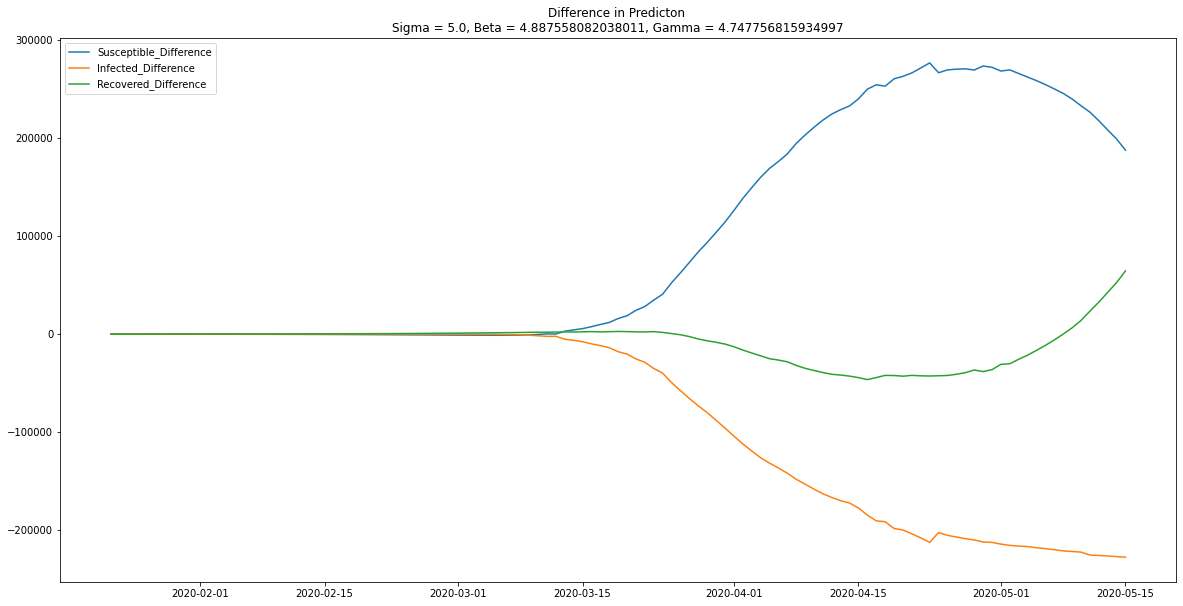

In [19]:
diff_all = get_diff_data_all()
plt.figure(figsize = (20,10))
plt.title('Difference in Predicton \nSigma = {0}, Beta = {1}, Gamma = {2}'.format(alpha,beta,gamma))
plt.plot(diff_all['Dates'].values,diff_all['Susceptible_Difference'].values,label = 'Susceptible_Difference')
plt.plot(diff_all['Dates'].values,diff_all['Infected_Difference'].values,label = 'Infected_Difference')
plt.plot(diff_all['Dates'].values,diff_all['Recovered_Difference'].values,label = 'Recovered_Difference')
plt.legend()
plt.show()


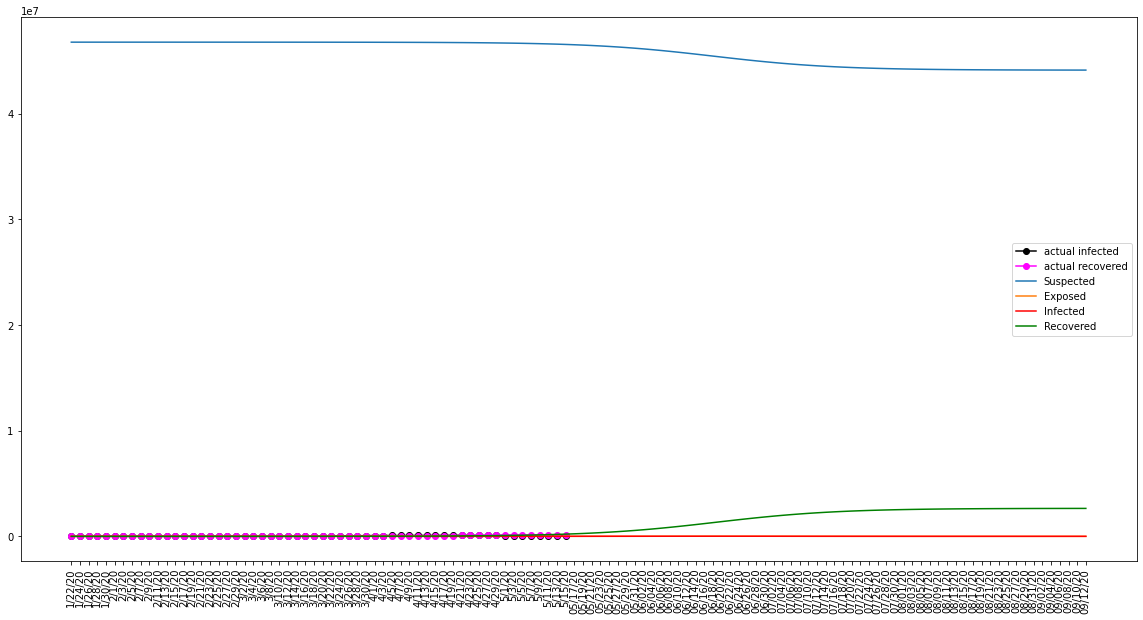

In [20]:
infected_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
recovered_actual = np.concatenate((full['Recovered'].values, [None] * (size - len(data.values))))

plt.figure(figsize=(20,10))
plt.plot(new_index[::2], infected_actual[::2], 'o-',color='black', label='actual infected')
plt.plot(new_index[::2], recovered_actual[::2], 'o-',color='magenta', label='actual recovered')
plt.plot(new_index[::2], predictUS.y[0,::2], label='Suspected')
plt.plot(new_index[::2], predictUS.y[1,::2], label='Exposed')
plt.plot(new_index[::2], predictUS.y[2,::2], label='Infected', color='red')
plt.plot(new_index[::2], predictUS.y[3,::2], label='Recovered', color='green')
plt.xticks(rotation=90)
plt.legend()

In [21]:
get_pred_data('2020-04-24')

,Susceptible,Exposed,Infected,Recovered
0,46700231,708,735,49945


In [22]:
get_real_data('2020-04-24')

,Susceptible,Infected,Recovered
0,46433750,202990,92355


In [23]:
get_diff_data('2020-04-13')

,Susceptible_Difference,Infected_Difference,Recovered_Difference
0,228885,-169756,-41703
